In [1]:
import pandas as pd
import numpy as np
import rapid_review as rr
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.svm import SVC, OneClassSVM
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import ast

## Pull the document metadata from the xml files from the Pubmed API

In [2]:
document_index = None

for fpath in os.listdir('../data/'):
    if "cohen_all" in fpath:
        ndf = rr.parse_pmxml(f'../data/{fpath}')
    if document_index is None:
        document_index = ndf
    else:
        document_index = pd.concat([document_index,ndf])
        
document_index["text"] = document_index["ab"] + document_index["mesh"]
document_index = document_index.drop_duplicates()
print(document_index.shape)
document_index.head()

(17238, 5)


,PMID,ab,mesh,ti,text
0,9793700,"This randomized, double-blind, placebo-control...",MESHHEADD000328 MESHHEADD001794 MESHHEADD0185...,Effect of subcutaneous naratriptan on forearm ...,"This randomized, double-blind, placebo-control..."
1,9793701,A multicenter test was conducted to investigat...,MESHHEADD000293 MESHHEADD000328 MESHHEADD0004...,Effect of operationalized computer diagnosis o...,A multicenter test was conducted to investigat...
2,9793702,Subcutaneous injection of sumatriptan is an ef...,MESHHEADD000280 MESHHEADD000328 MESHHEADD0003...,Sumatriptan nasal spray (20 mg/dose) in the ac...,Subcutaneous injection of sumatriptan is an ef...
3,9793771,The efficacy and adverse effects of 0.25% apra...,MESHHEADD000316 MESHHEADD000319 MESHHEADD0003...,The effect of 0.25% apraclonidine in preventin...,The efficacy and adverse effects of 0.25% apra...
4,9793807,To determine if an intravenous (i.v.) fluid bo...,MESHHEADD000328 MESHHEADD015360 MESHHEADD0163...,An intravenous fluid bolus is not necessary be...,To determine if an intravenous (i.v.) fluid bo...


In [3]:
document_index.iloc[1, 4]

'A multicenter test was conducted to investigate the effectiveness of the selective serotonin agonist sumatriptan in patients with the computerized headache diagnosis of migraine. A computer program was used for diagnostic evaluation of patients attending a general practice because of headache. The results of the analysis were taken as a direct decision on therapy. If the patients satisfied the criteria for migraine, they were given subcutaneous sumatriptan for treating three migraine attacks. The patients were able to use the study medication under outpatient conditions. The therapeutic efficacy of the medicine was recorded in a headache diary. A total of 91 patients were included in the study at 22 practices in Germany. An average of four patients per practice were recruited. In the first migraine attack treated, headache improvement was experienced by 77.7% of the patients treated. In the second and third attacks an improvement was experienced by 93.5% and 89.8%, respectively. The r

## Load the cohen database of SRs
https://dmice.ohsu.edu/cohenaa/systematic-drug-class-review-data.html

In [190]:
cohen_db = pd.read_csv(
    '../data/epc-ir.clean.tsv',
    sep='\t',header=None,
    #names=["review","EID","PMID","relevant","fulltext_relevant"]
    names=["review","EID","PMID","relevant_ab","relevant"]
)

cohen_db['relevant'] = np.where(cohen_db['relevant']=="I",1,0)
cohen_db = cohen_db[["review","PMID","relevant"]]

cohen_db.head()



,review,PMID,relevant
0,ACEInhibitors,10024335,0
1,ACEInhibitors,10027665,0
2,ACEInhibitors,10027935,0
3,ACEInhibitors,10028936,0
4,ACEInhibitors,10029645,0


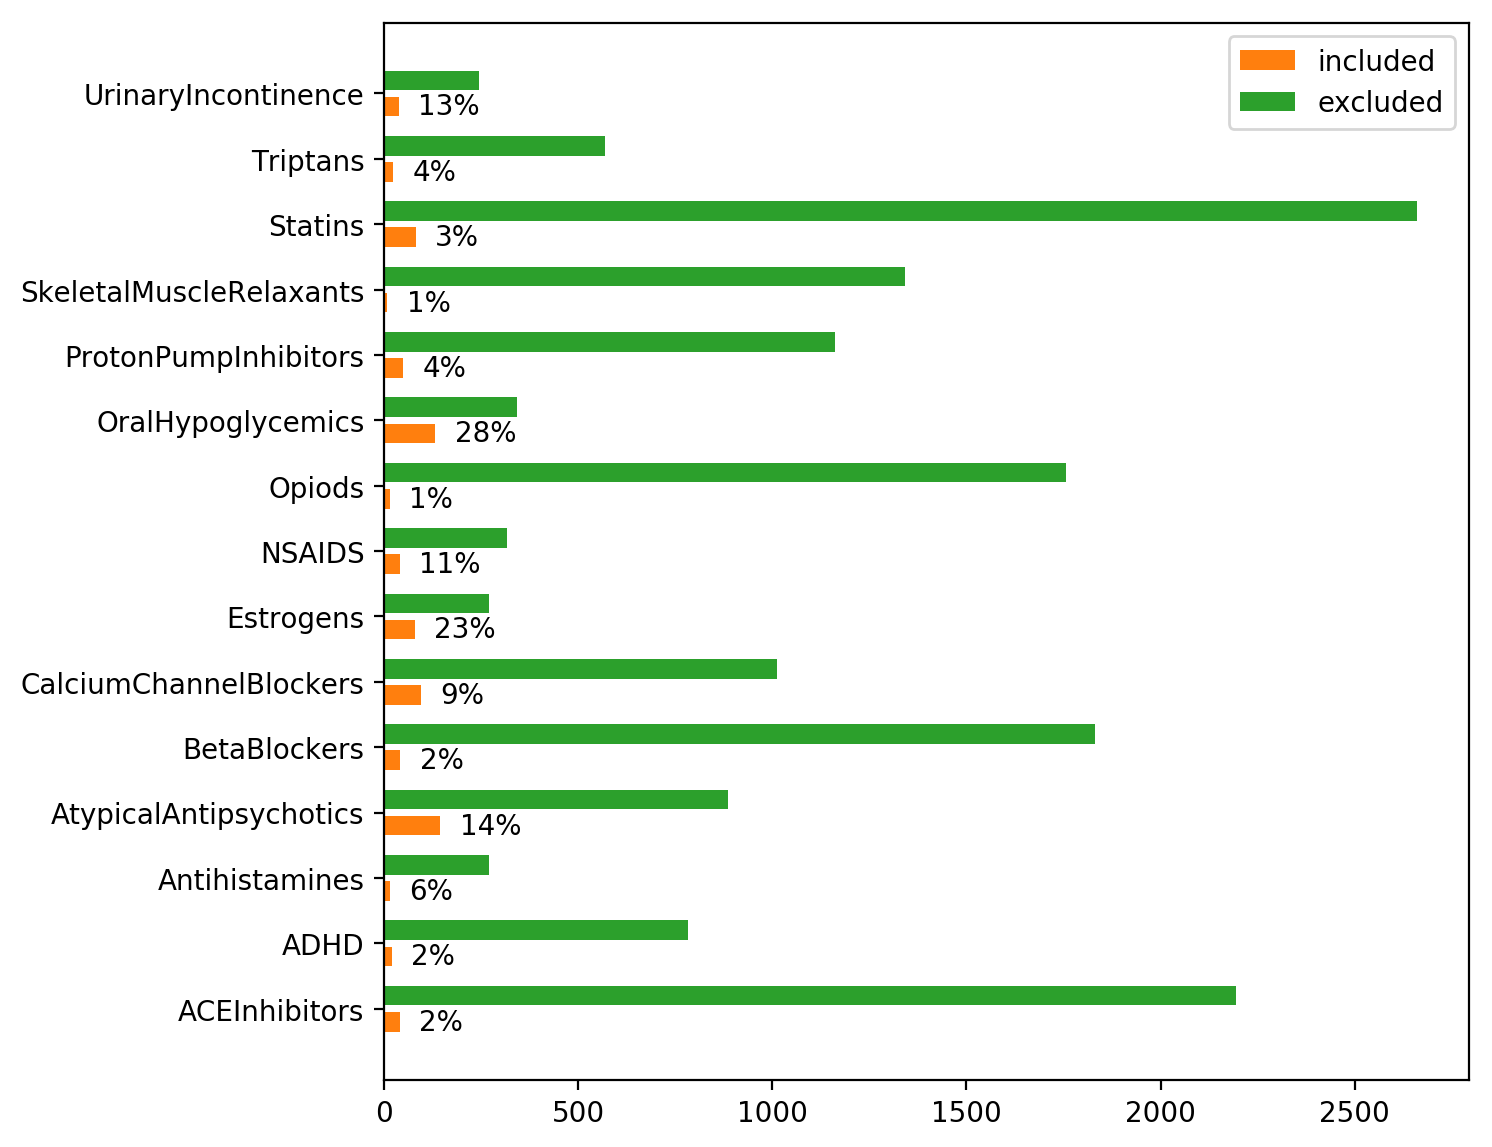

In [191]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

cm = plt.cm.RdYlBu


ticklabels = []
for i, (name, group) in enumerate(cohen_db.groupby('review')):
    if i==0:
        l1="included"
        l2="excluded"
    else:
        l1 = None
        l2 = None
        
    group = pd.merge(
        group,
        document_index,
    )
    group = group.dropna()
    included = group[group['relevant']==1].shape[0]
    excluded = group[group['relevant']==0].shape[0]
    ax.barh(i-0.2, included, height=0.3, color='C1',label=l1)
    ax.barh(i+0.2, excluded, height=0.3, color='C2', label=l2)
    ax.text(included+50, i-0.2, f'{included/(included+excluded):.0%}', ha="left", va="center")
    ticklabels.append(name)
        
ax.set_yticks([i for i,v in enumerate(ticklabels)])
ax.set_yticklabels(ticklabels)

ax.legend()
    
    
plt.show()

In [279]:
importlib.reload(rr)

recalculate = True
if recalculate:
    models = [
        SVC(kernel='linear',class_weight='balanced',probability=True)
        #MultinomialNB(alpha=0.1)    
        #MLPClassifier(
        #    solver='lbfgs', 
        #    alpha=0.1,
        #    hidden_layer_sizes=(10), 
        #    random_state=1
        #)
    ]
    iterations = 1

    results = []
    rs_results = []
    paths = []
    for name, group in cohen_db.groupby('review'):
        df = pd.merge(
            group,
            document_index,
        )
        df['x'] = df['mesh']
        df = df[df['x']!=" "]
        df = df.dropna().reset_index(drop=True)
        #if df.shape[0] > 1000:
            #continue
        if name not in ["AtypicalAntipsychotics"]:#,"BetaBlockers"]:
            continue
        ss = rr.ScreenScenario(
            df, models, 500, [50,100,200], name
        )
        for i in range(iterations):
            results.append(ss.screen(i, True))
            #print(ss.recall_rs)
        break

    results_df = pd.DataFrame.from_dict(results)

    
else:
    results_df = pd.read_csv('../results/results.csv')
    for p in ["estimated_recall_path", "recall_track", "work_track","random_work_track","random_recall_track"]:
        results_df[p] = results_df[p].apply(ast.literal_eval)
    
#rs_results_df.head()    


Dataset: AtypicalAntipsychotics, iteration 0.  1030 out of 1030 documents seen (100%) - recall: 100.00%, probable recall: 0.00%


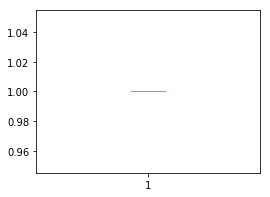

In [273]:
fig, ax = plt.subplots(figsize=(4,3))
#ax.boxplot([results_df['random_start_recall'], results_df['recall_rs']], whis=[0.05,0.95])
ax.boxplot([results_df['recall_rs']], whis=[0.05,0.95])
plt.show()

In [10]:
#results_df[['bir','last_iteration_relevance','wss95_rs']]

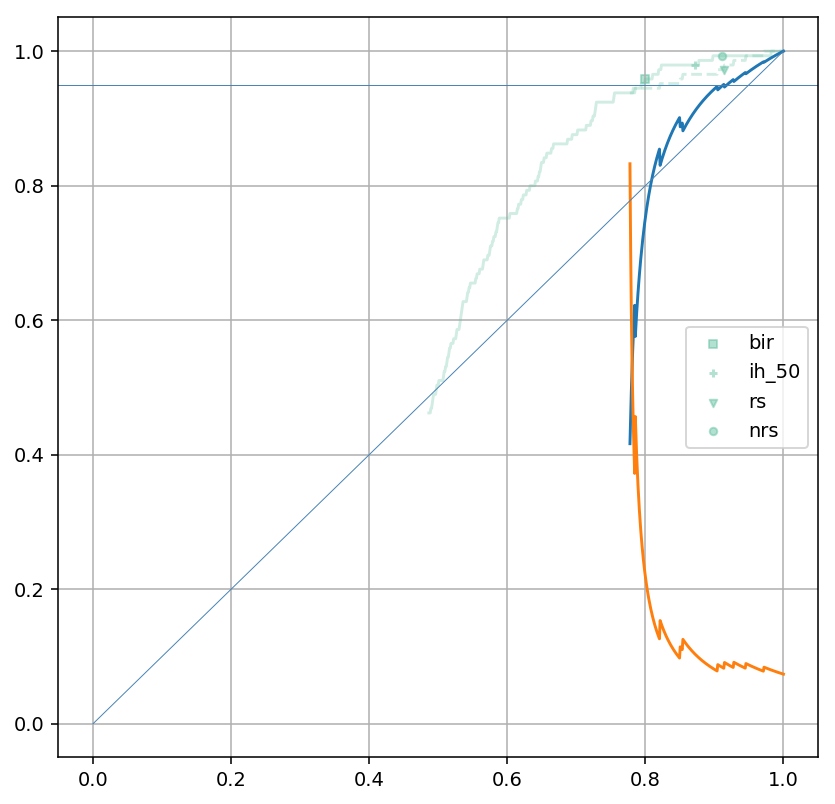

In [280]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.3
size = 15

pdf = results_df#[results_df['N'] > 1000]

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)
    ax.plot(p['random_work_track'], p['random_recall_track'], c = colors[0], alpha=a, linestyle="--")
    ax.plot(p['random_work_track'], p['estimated_recall_path'])
    ax.plot(p['random_work_track'], p['estimated_p_path'])
    
s_crit = ["bir","ih_50","rs","nrs"]

import itertools
marker = itertools.cycle((',', '+', 'v', 'o', '*',':')) 

#ax.scatter(pdf['random_start_work'],pdf['random_start_recall'],c=colors[0],s=size,alpha=a+0.2)

for s in s_crit:
    ax.scatter(
        1- pdf[f'wss95_{s}'], 
        pdf[f'recall_{s}'], 
        c = colors[0], marker = next(marker),
        label = s,
        s = size,
        alpha=a+0.2
    )
    
ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.legend()
ax.grid()

plt.show()

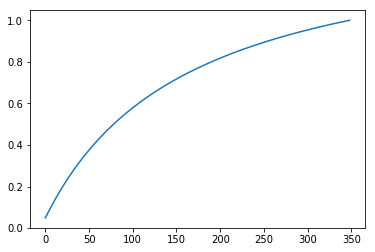

In [261]:
fig, ax = plt.subplots()
ax.plot(list(range(len(p['estimated_recall_path']))), p['estimated_recall_path'])

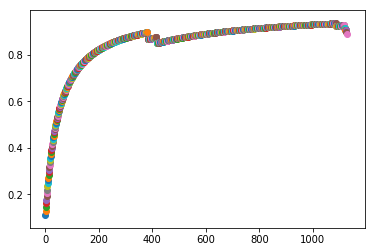

In [275]:
self = ss
X = 0
for n, j in enumerate(self.ratings[::-1]):
    X+=j
    p_tilde, ci = rr.ci_ac(X, n+1, 0.95)
    estimated_r_docs = (p_tilde+ci)*(self.N-self.seen_docs) + self.r_seen
    estimated_recall_min = self.r_seen / estimated_r_docs  
        
        
    plt.scatter(n, estimated_recall_min)

In [239]:
self = ss
self.df[self.df['relevant'] - self.df['seen'] == 1]


,review,PMID,relevant,ab,mesh,ti,text,x,seen,outlying


In [225]:
self.df[self.df['relevant'] + self.df['seen'] == 2]

,review,PMID,relevant,ab,mesh,ti,text,x,seen,outlying
54,Opiods,10229408,1,To compare the efficacy and safety of controll...,MESHHEADD000082 MESHHEADD000328 MESHHEADD0003...,Treatment of osteoarthritis pain with controll...,To compare the efficacy and safety of controll...,MESHHEADD000082 MESHHEADD000328 MESHHEADD0003...,1,1
158,Opiods,10524470,1,To compare the efficacy and safety of controll...,MESHHEADD000701 MESHHEADD001416 MESHHEADD0029...,Efficacy and safety of controlled-release vers...,To compare the efficacy and safety of controll...,MESHHEADD000701 MESHHEADD001416 MESHHEADD0029...,1,1
168,Opiods,10541775,1,This study evaluated Repro-Dose morphine (RDM;...,MESHHEADD000284 MESHHEADD000368 MESHHEADD0007...,Assessment of analgesia in human chronic pain....,This study evaluated Repro-Dose morphine (RDM;...,MESHHEADD000284 MESHHEADD000368 MESHHEADD0007...,1,1
245,Opiods,10737286,1,Although opioid analgesics have well-defined e...,MESHHEADD000368 MESHHEADD000701 MESHHEADD0036...,"Around-the-clock, controlled-release oxycodone...",Although opioid analgesics have well-defined e...,MESHHEADD000368 MESHHEADD000701 MESHHEADD0036...,1,1
254,Opiods,10743822,1,Pain is the cardinal feature of osteoarthritis...,MESHHEADD000082 MESHHEADD000368 MESHHEADD0187...,Double blind randomized placebo control trial ...,Pain is the cardinal feature of osteoarthritis...,MESHHEADD000082 MESHHEADD000368 MESHHEADD0187...,1,1
428,Opiods,11166969,1,The efficacy of oral retarded morphine sulphat...,MESHHEADD000328 MESHHEADD000368 MESHHEADD0006...,The effect of opioids on phantom limb pain and...,The efficacy of oral retarded morphine sulphat...,MESHHEADD000328 MESHHEADD000368 MESHHEADD0006...,1,1
490,Opiods,11348910,1,To compare patients' preference for transderma...,MESHHEADD000279 MESHHEADD000328 MESHHEADD0003...,Randomised crossover trial of transdermal fent...,To compare patients' preference for transderma...,MESHHEADD000279 MESHHEADD000328 MESHHEADD0003...,1,1
668,Opiods,12215866,1,Pain relief for patients with osteoporosis is ...,MESHHEADD000279 MESHHEADD000368 MESHHEADD0003...,Transdermal fentanyl for the treatment of back...,Pain relief for patients with osteoporosis is ...,MESHHEADD000279 MESHHEADD000368 MESHHEADD0003...,1,1
821,Opiods,12855350,1,Morphine is increasingly used in patients with...,MESHHEADD000284 MESHHEADD000293 MESHHEADD0003...,Long term effects of oral sustained release mo...,Morphine is increasingly used in patients with...,MESHHEADD000284 MESHHEADD000293 MESHHEADD0003...,1,1
1076,Opiods,8544547,1,The use of opioid analgesics for chronic non-c...,MESHHEADD000284 MESHHEADD000293 MESHHEADD0003...,Randomised trial of oral morphine for chronic ...,The use of opioid analgesics for chronic non-c...,MESHHEADD000284 MESHHEADD000293 MESHHEADD0003...,1,1


In [231]:
sr = self.df[self.df['relevant'] + self.df['seen'] == 2]
for m in self.df[self.df['relevant'] - self.df['seen'] == 1].reset_index(drop=True).loc[0, 'x'].split():
    print(m)
    print(sr[sr['x'].str.contains(m)].shape[0])


MESHHEADD000284
3
MESHHEADD000818
0
MESHHEADD003072
0
MESHHEADD003248
0
MESHHEADD003937
0
MESHHEADD004347
0
MESHHEADD006801
13
MESHHEADD009020
6
MESHHEADD009207
0
MESHHEADD009294
0
MESHHEADD014839
0


In [232]:
for m in self.df[self.df['relevant'] - self.df['seen'] == -1].reset_index(drop=True).loc[0, 'x'].split():
    print(m)
    print(sr[sr['x'].str.contains(m)].shape[0])

MESHHEADD000293
2
MESHHEADD016058
0
MESHHEADD000701
12
MESHHEADD000932
0
MESHHEADD002648
0
MESHHEADD002675
0
MESHHEADD004311
8
MESHHEADD005260
13
MESHHEADD006801
13
MESHHEADD007275
0
MESHHEADD008297
13
MESHHEADD009020
6
MESHHEADD010149
0
MESHHEADD010640
0
MESHHEADD020250
0
MESHHEADD011446
3


In [126]:
X = 0 

last = self.random_start_recall
print(last)
for i in self.random_recall_track:
    if i > last:
        X+=1
    last = i
    
print(X)
n = len(self.random_recall_track)

p_tilde, ci = rr.ci_ac(X, n, 0.95)

print(p_tilde, ci)

0.18604651162790697
32
0.028556613476030758 0.00947176579844235


In [150]:
import math
self.estimated_r_docs = round((p_tilde+ci)*self.n_remaining) + self.r_seen
print(self.estimated_r_docs)

self.estimated_r_docs = (p_tilde+ci)*self.n_remaining + self.r_seen
print(self.estimated_r_docs)

print(self.estimated_recall_min)

print(self.r_seen/self.estimated_r_docs)

43.0
43.0
1.0
1.0


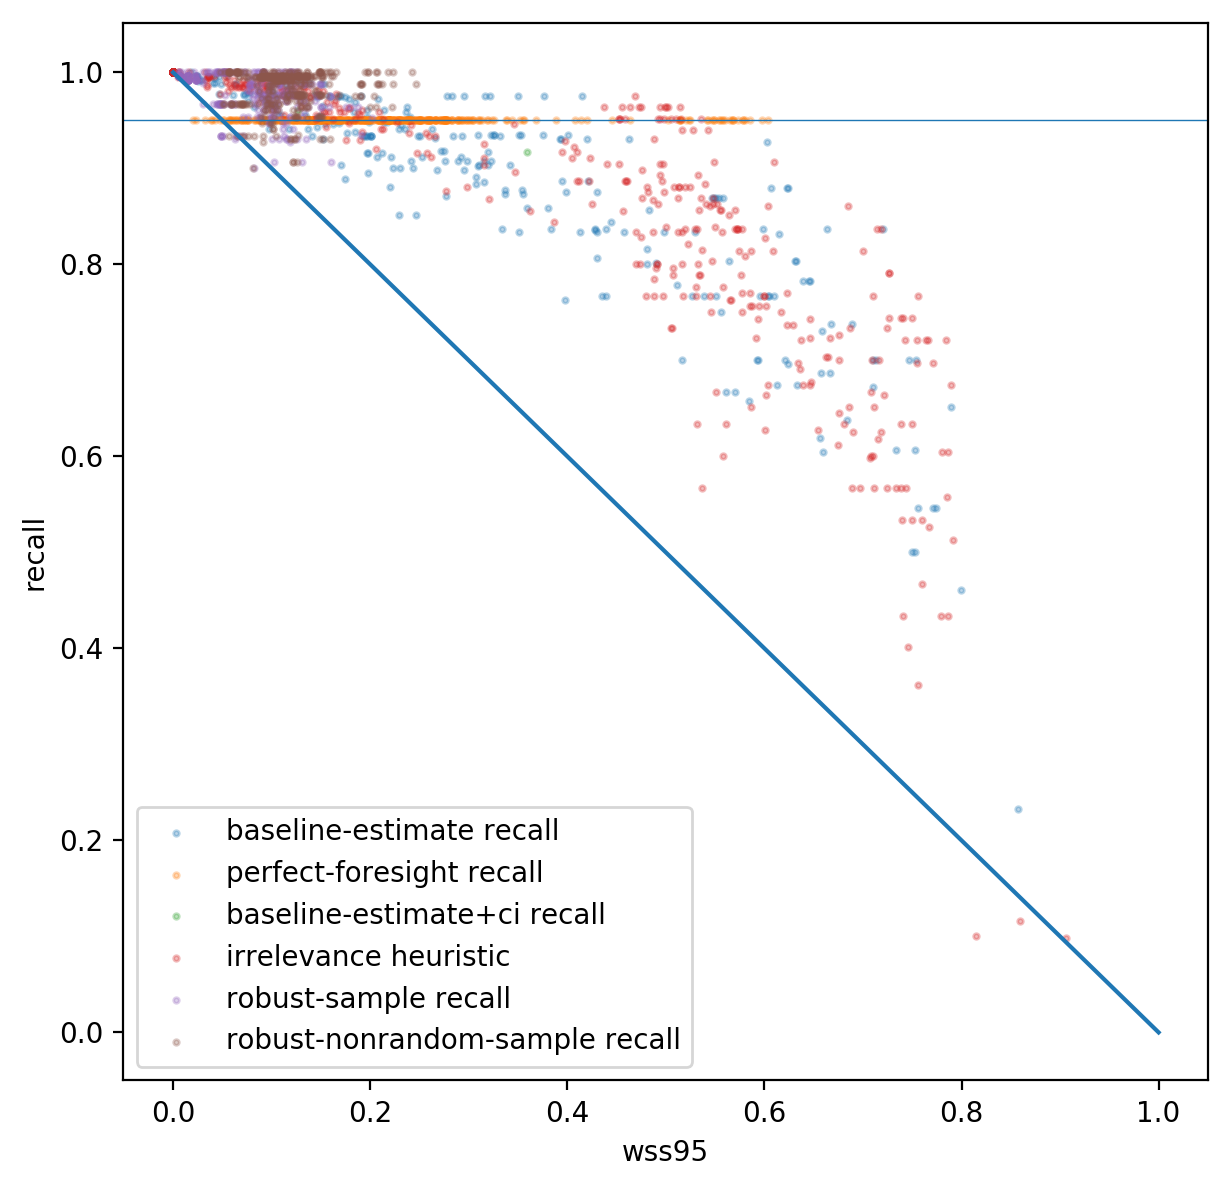

In [11]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
s = 4
a = 0.3
ax.scatter(
    results_df['wss95_bir'], results_df['recall_bir'], 
    alpha=a, 
    label="baseline-estimate recall",
    s=s
)
ax.scatter(
    results_df['wss95_pf'], 
    [0.95 for x in results_df['recall_pf']], 
    alpha=a,
    label="perfect-foresight recall",
    s=s
)

ax.scatter(
    results_df['wss95_bir_ci'], 
    results_df['recall_bir_ci'], 
    alpha=a,
    label="baseline-estimate+ci recall",
    s=s
)

ax.scatter(
    results_df['wss95_ih_50'], 
    results_df['recall_ih_50'], 
    alpha=a,
    label="irrelevance heuristic",
    s=s
)

ax.scatter(
    results_df['wss95_rs'], results_df['recall_rs'], 
    alpha=a, 
    label="robust-sample recall",
    s=s
)

ax.scatter(
    results_df['wss95_nrs'], results_df['recall_rs'], 
    alpha=a, 
    label="robust-nonrandom-sample recall",
    s=s
)

ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.plot([1,0],)

ax.axhline(0.95, lw=0.5)
plt.show()

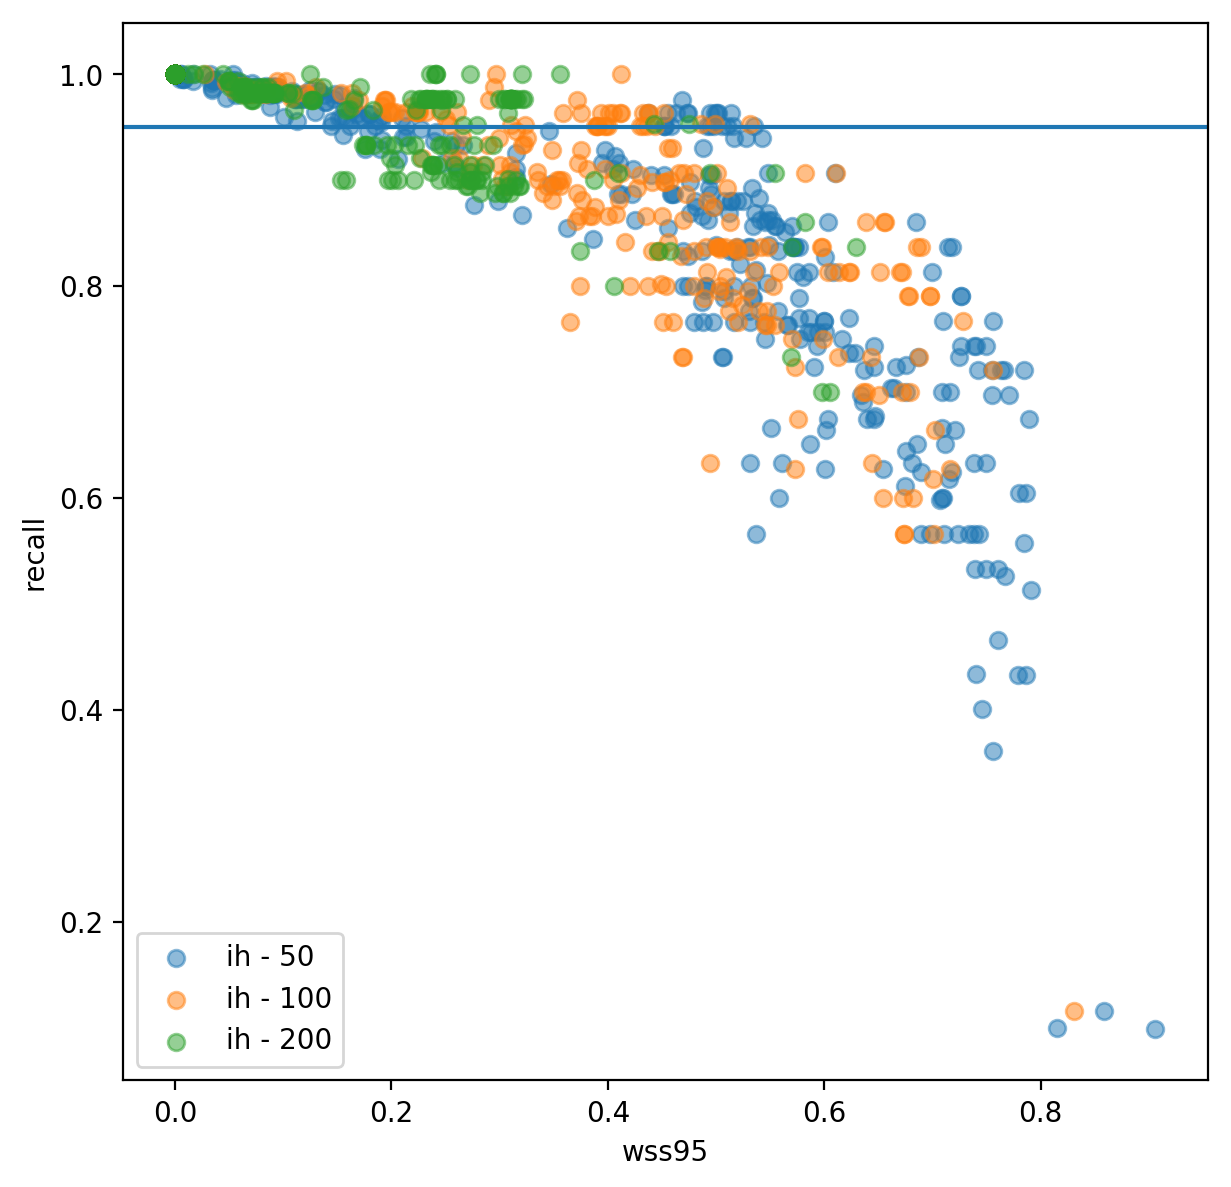

In [12]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
for ih in [50,100,200]:
    ax.scatter(
        results_df[f'wss95_ih_{ih}'], results_df[f'recall_ih_{ih}'], 
        alpha=0.5, 
        label=f"ih - {ih}"
    )


ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.axhline(0.95)
plt.show()

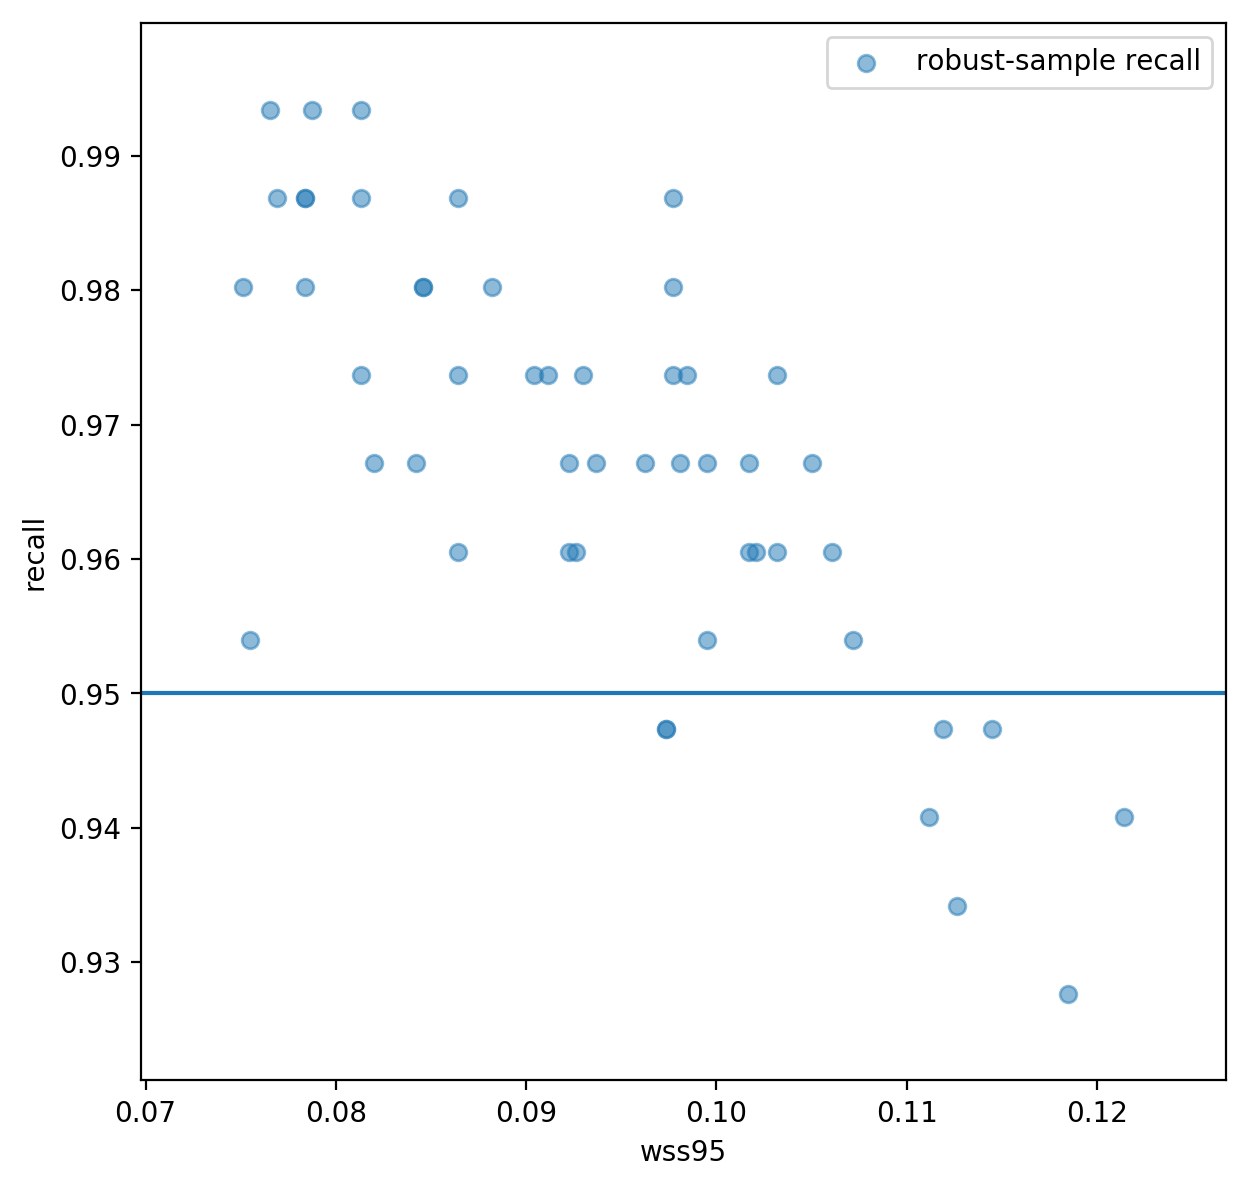

In [13]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

pdf = results_df.query('N > 2500')

ax.scatter(
    pdf['wss95_rs'], pdf['recall_rs'], 
    alpha=0.5, 
    label="robust-sample recall"
)


ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.axhline(0.95)
plt.show()

5
1


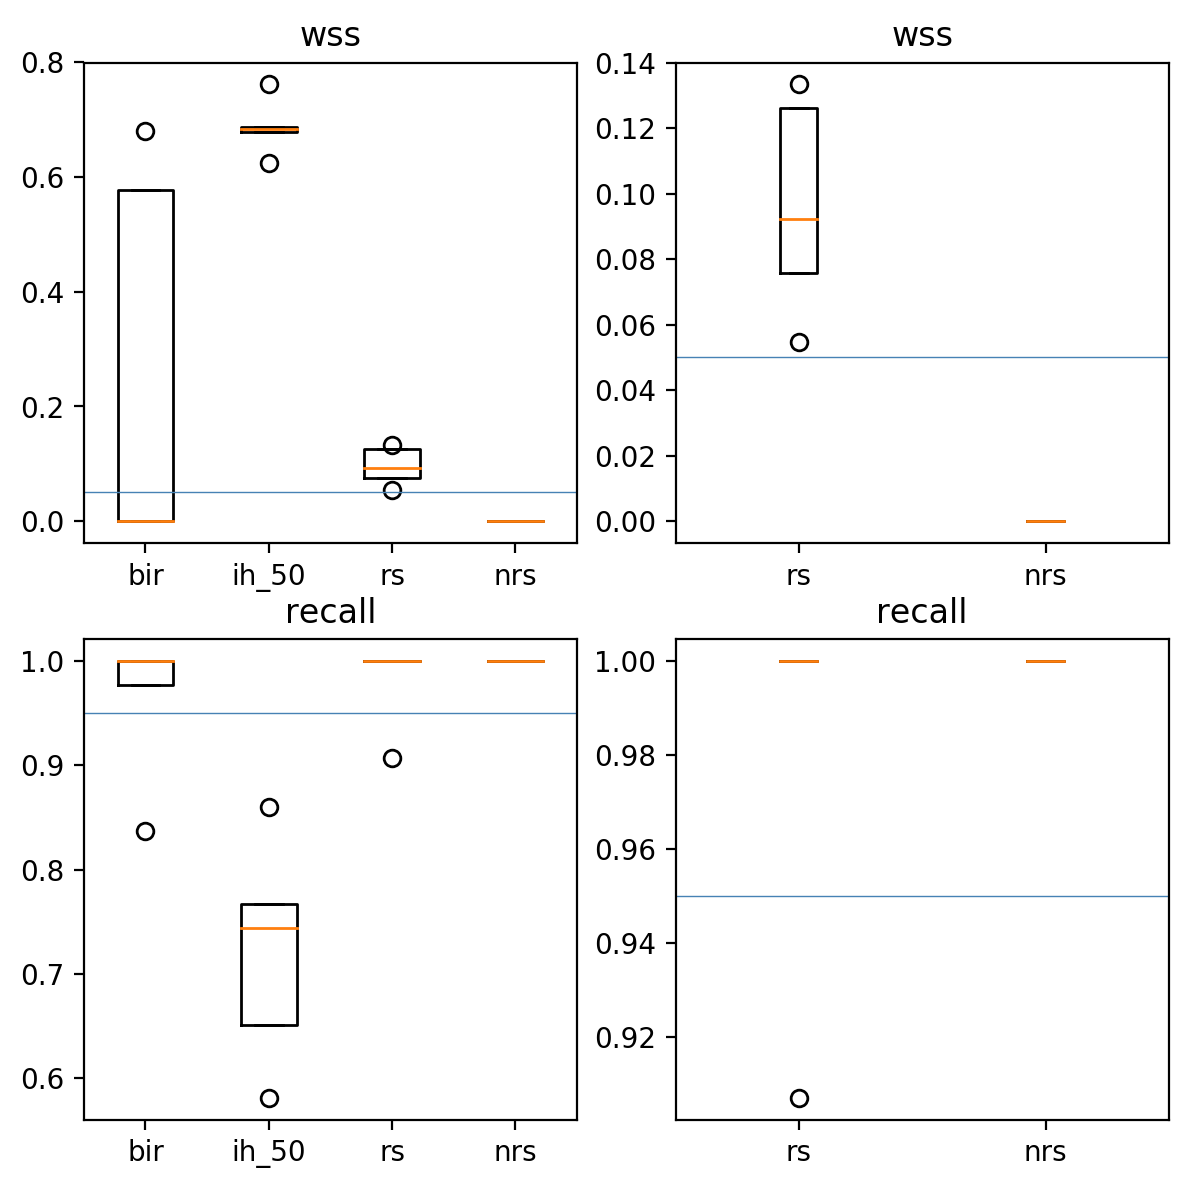

In [138]:
fig, axs = plt.subplots(2,2, figsize=(7,7),dpi=200)

rs_crit = ['rs','nrs']

pdf = results_df[(results_df['N'] > 1500) & (pd.notnull(results_df['recall_pf']))]

print(pdf.shape[0])

print(len(pdf['dataset'].unique()))

for i, c in enumerate([s_crit, rs_crit]):
    
    for j in [(0,'wss95',0.05), (1,'recall',0.95)]:

        axs[j[0]][i].boxplot([pdf[f'{j[1]}_{s}'].dropna() for s in c],whis=[0.05,0.95])
        axs[j[0]][i].set_xticklabels(c)
        axs[j[0]][i].axhline(j[2], color="steelblue",lw=0.5)
        
        axs[j[0]][i].set_title(j[1].replace('95',''))

plt.show()

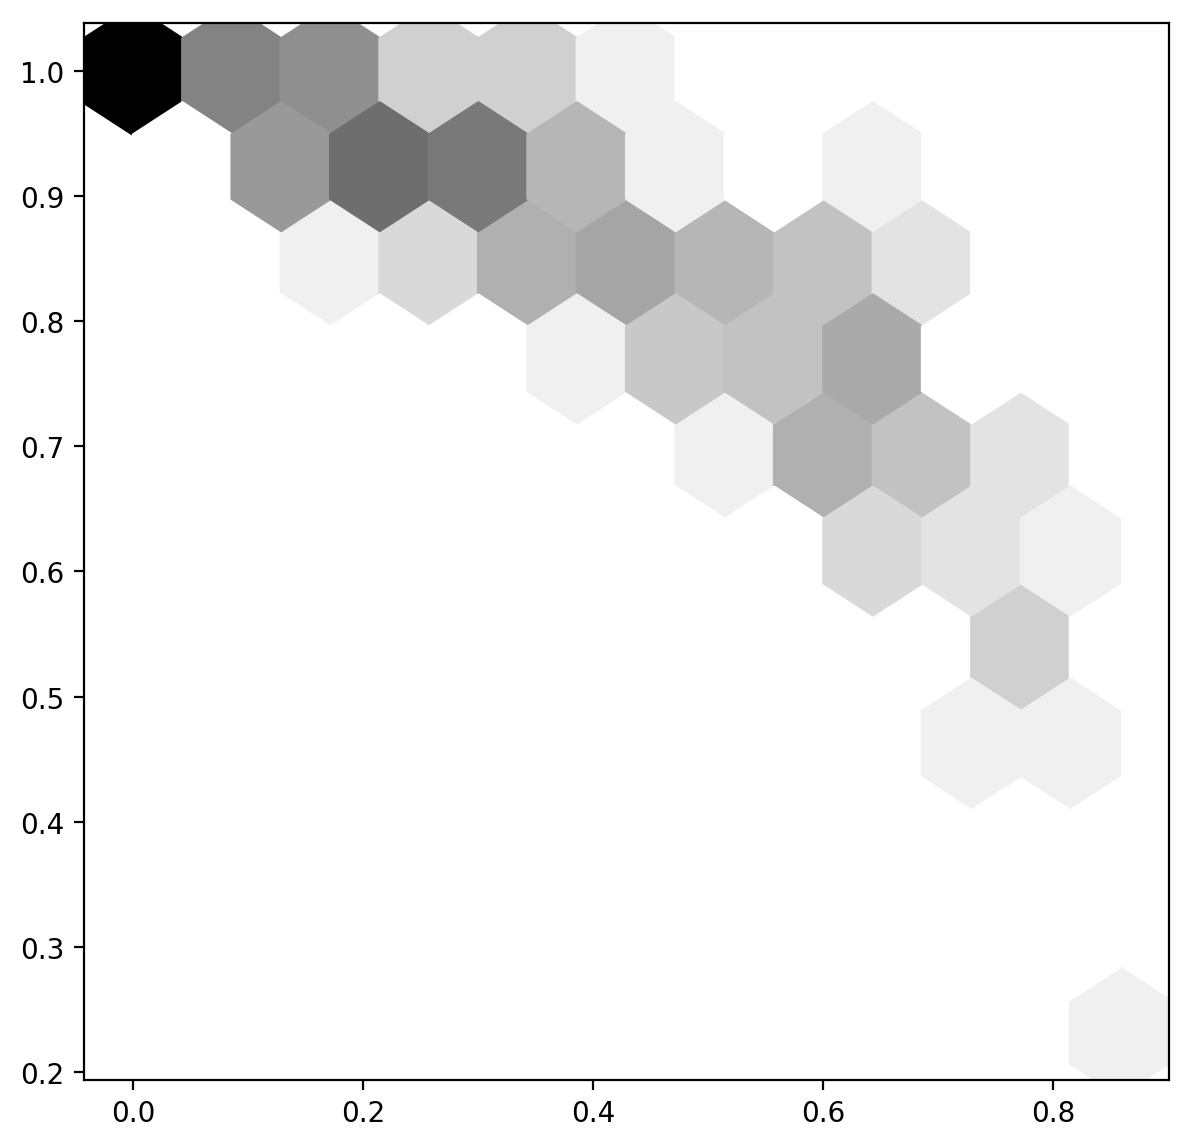

In [52]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.hexbin(
    results_df['wss95_bir'], 
    results_df['recall_bir'], 
    gridsize=10, 
    mincnt=0,
    bins="log",
    cmap = "Greys"
)
plt.show()

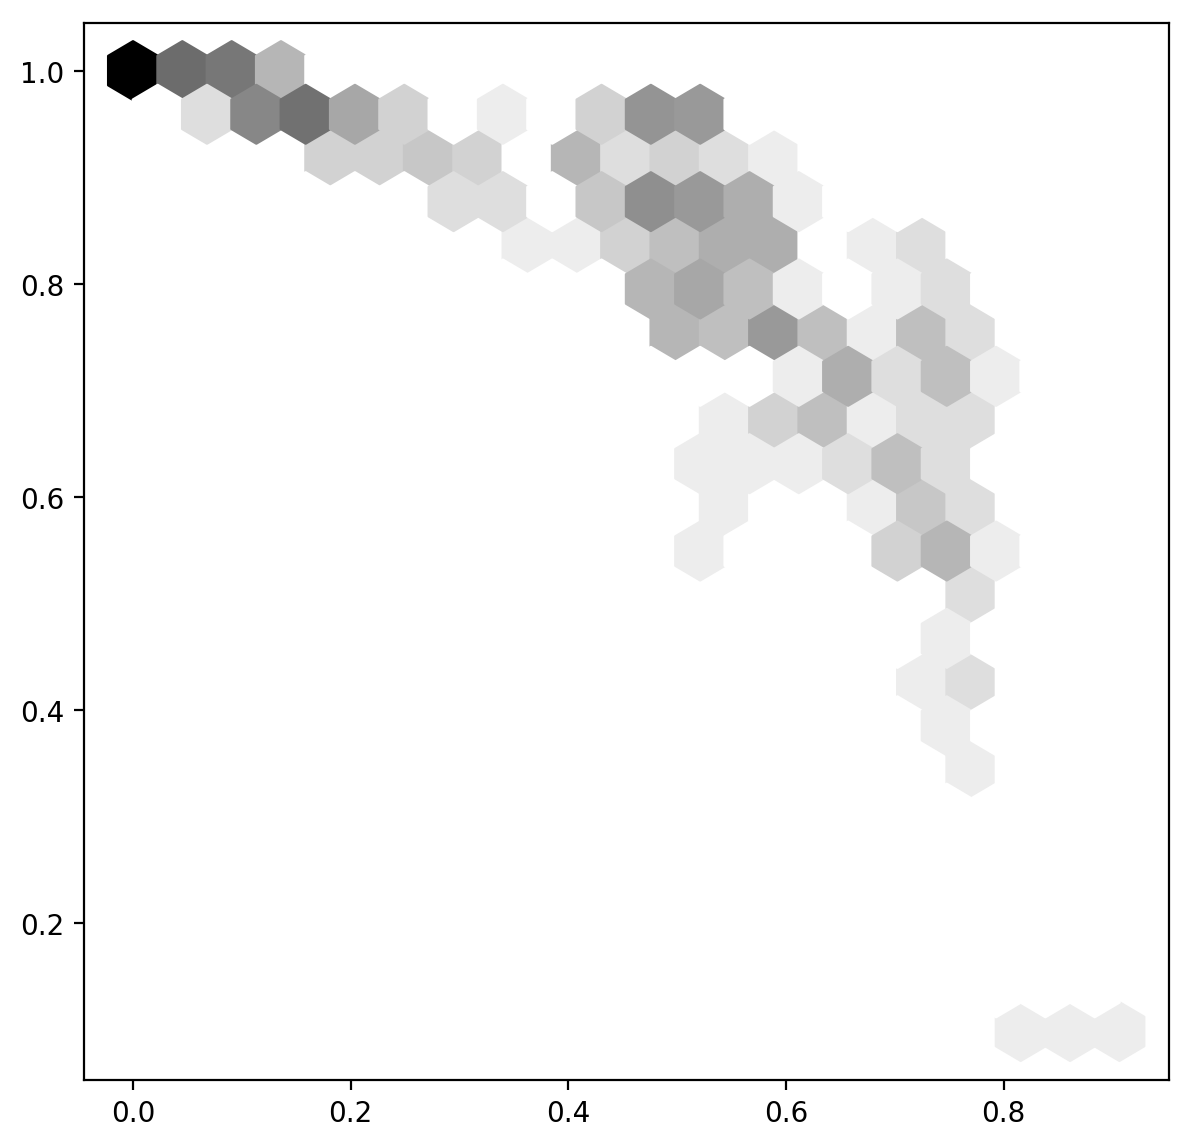

In [54]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.hexbin(
    results_df['wss95_ih_50'], 
    results_df['recall_ih_50'], 
    gridsize=20, 
    mincnt=0,
    cmap="Greys",
    bins="log"
)
plt.show()

['wss95_bir',
 'wss95_ih_50',
 'wss95_rs',
 'wss95_nrs',
 'recall_bir',
 'recall_ih_50',
 'recall_rs',
 'recall_nrs']

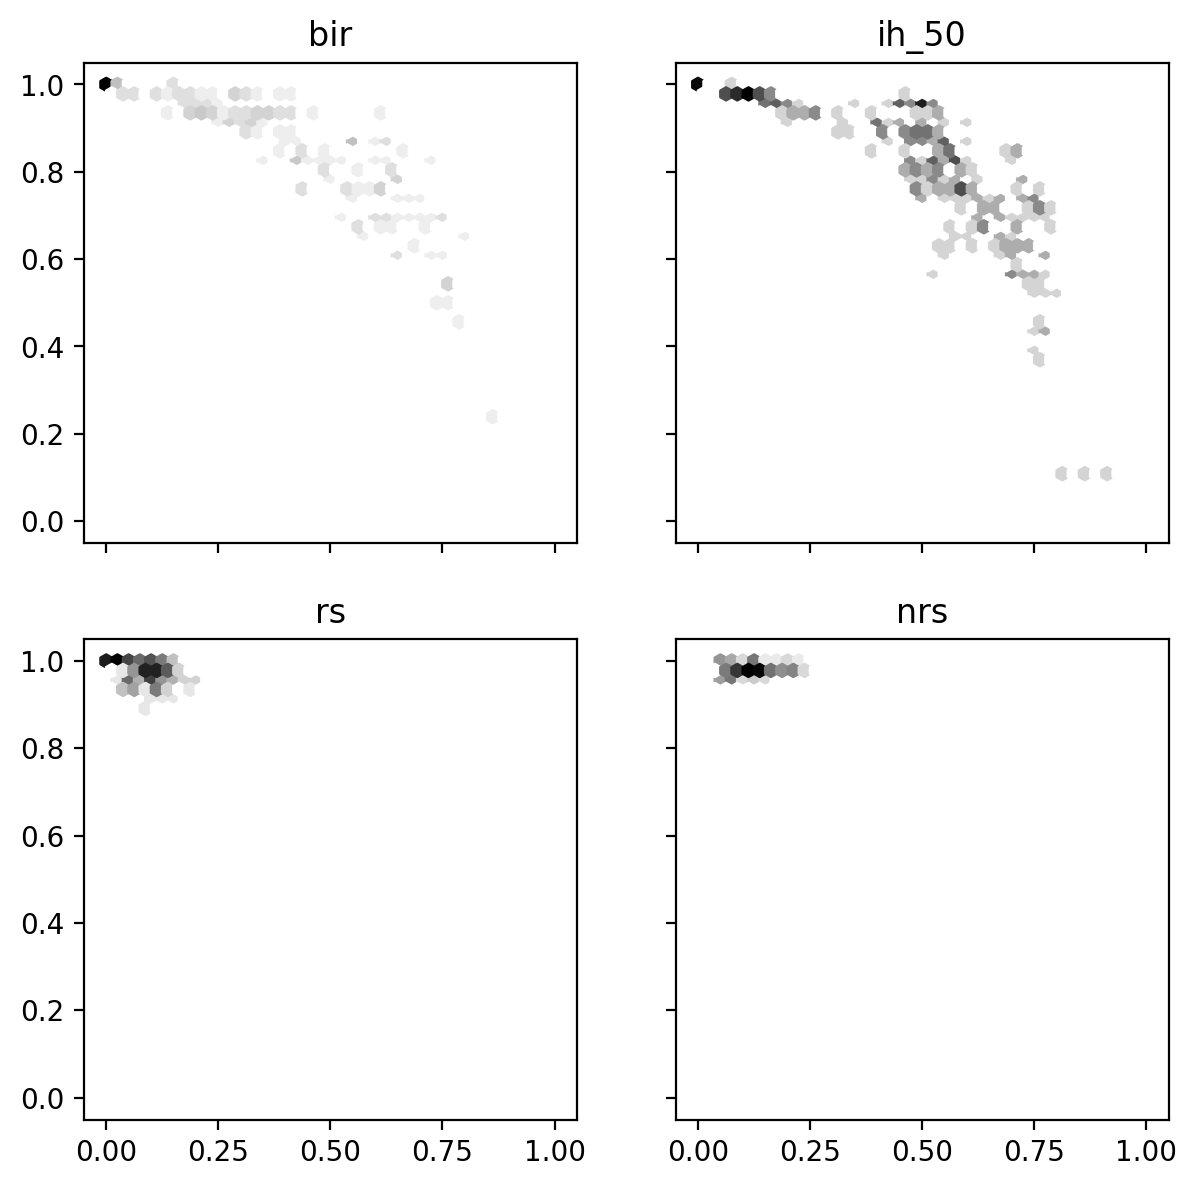

In [59]:
fig, axs = plt.subplots(2,2,figsize=(7,7),dpi=200,sharey=True, sharex=True)

cols = [f'wss95_{s}' for s in s_crit] + [f'recall_{s}' for s in s_crit]

pdf = results_df[cols].dropna()

for i, ss in enumerate(s_crit):
    ax = axs[i//2][i%2]
    ax.hexbin(
        pdf[f'wss95_{ss}'].dropna(), 
        pdf[f'recall_{ss}'].dropna(), 
        gridsize=40, 
        mincnt=0,
        cmap="Greys",
        bins="log",
        extent=[0, 1, 0, 1]
    )
    ax.set_title(ss)
plt.show()    

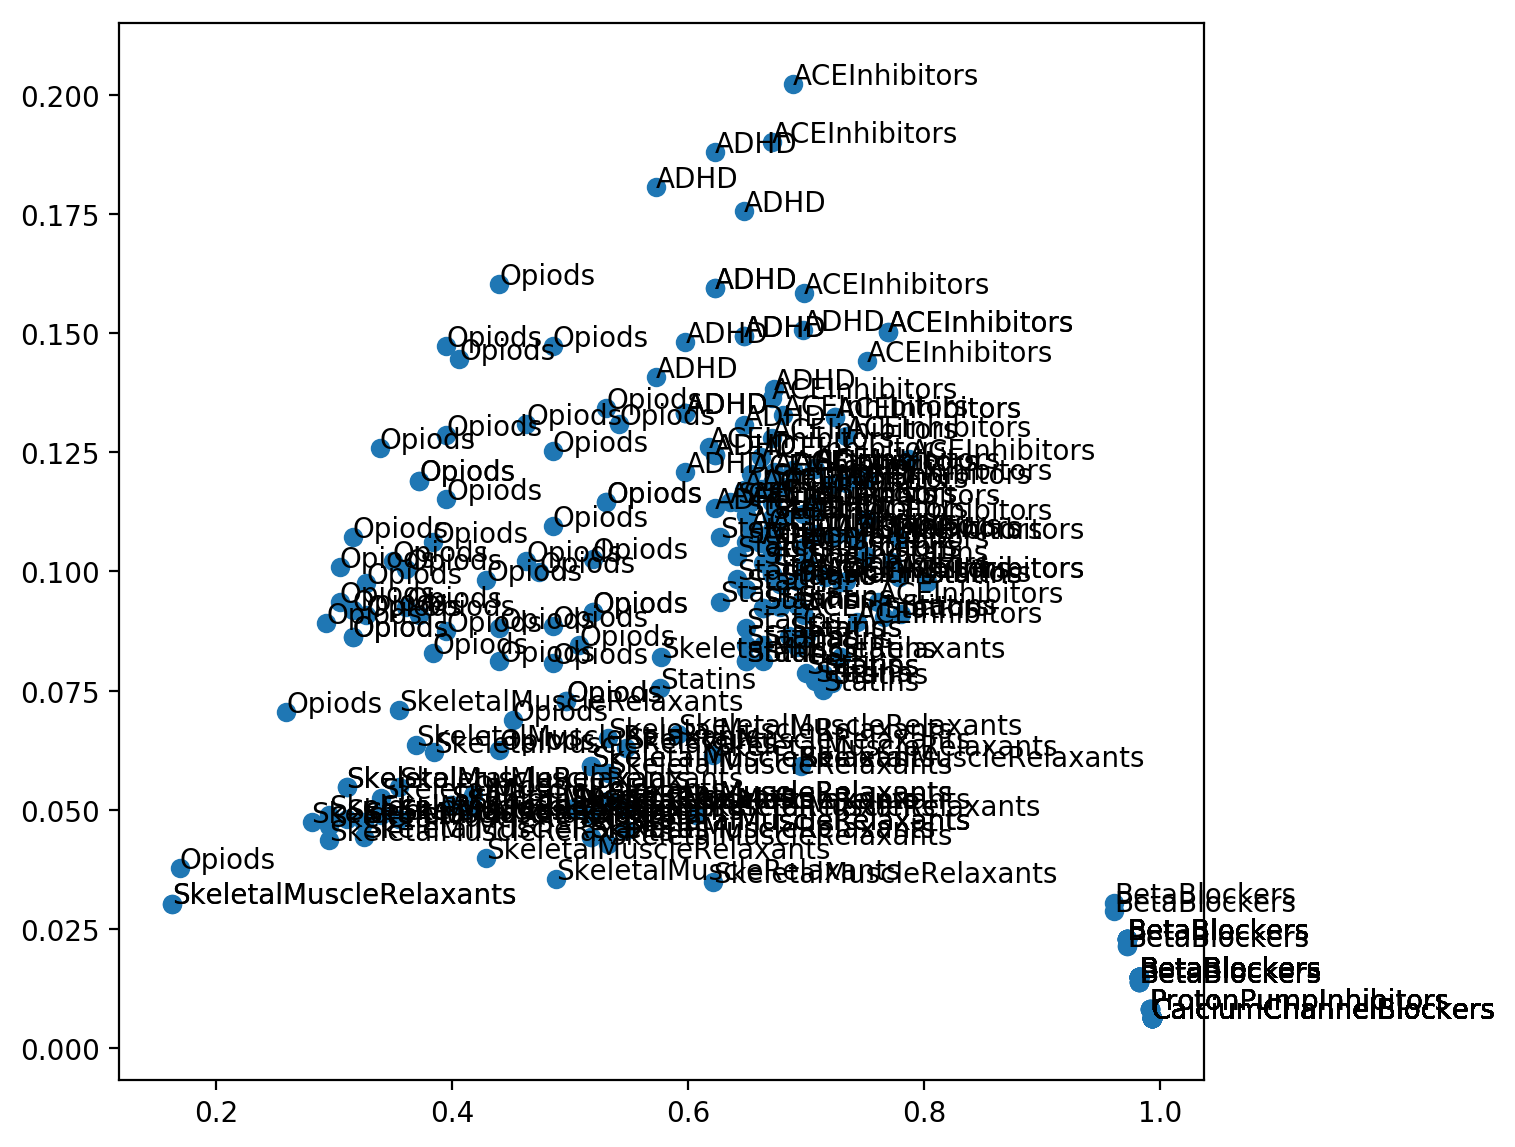

In [70]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

df = results_df
df = df.loc[df[['random_start_work','wss95_rs']].dropna().index,:]

x = 'random_start_work'

ax.scatter(
    df[x], 
    df['wss95_rs'], 
)
for i, row in df.iterrows():
    ax.text(
        row[x], 
        row['wss95_rs'], 
        row['dataset']
    )
plt.show()

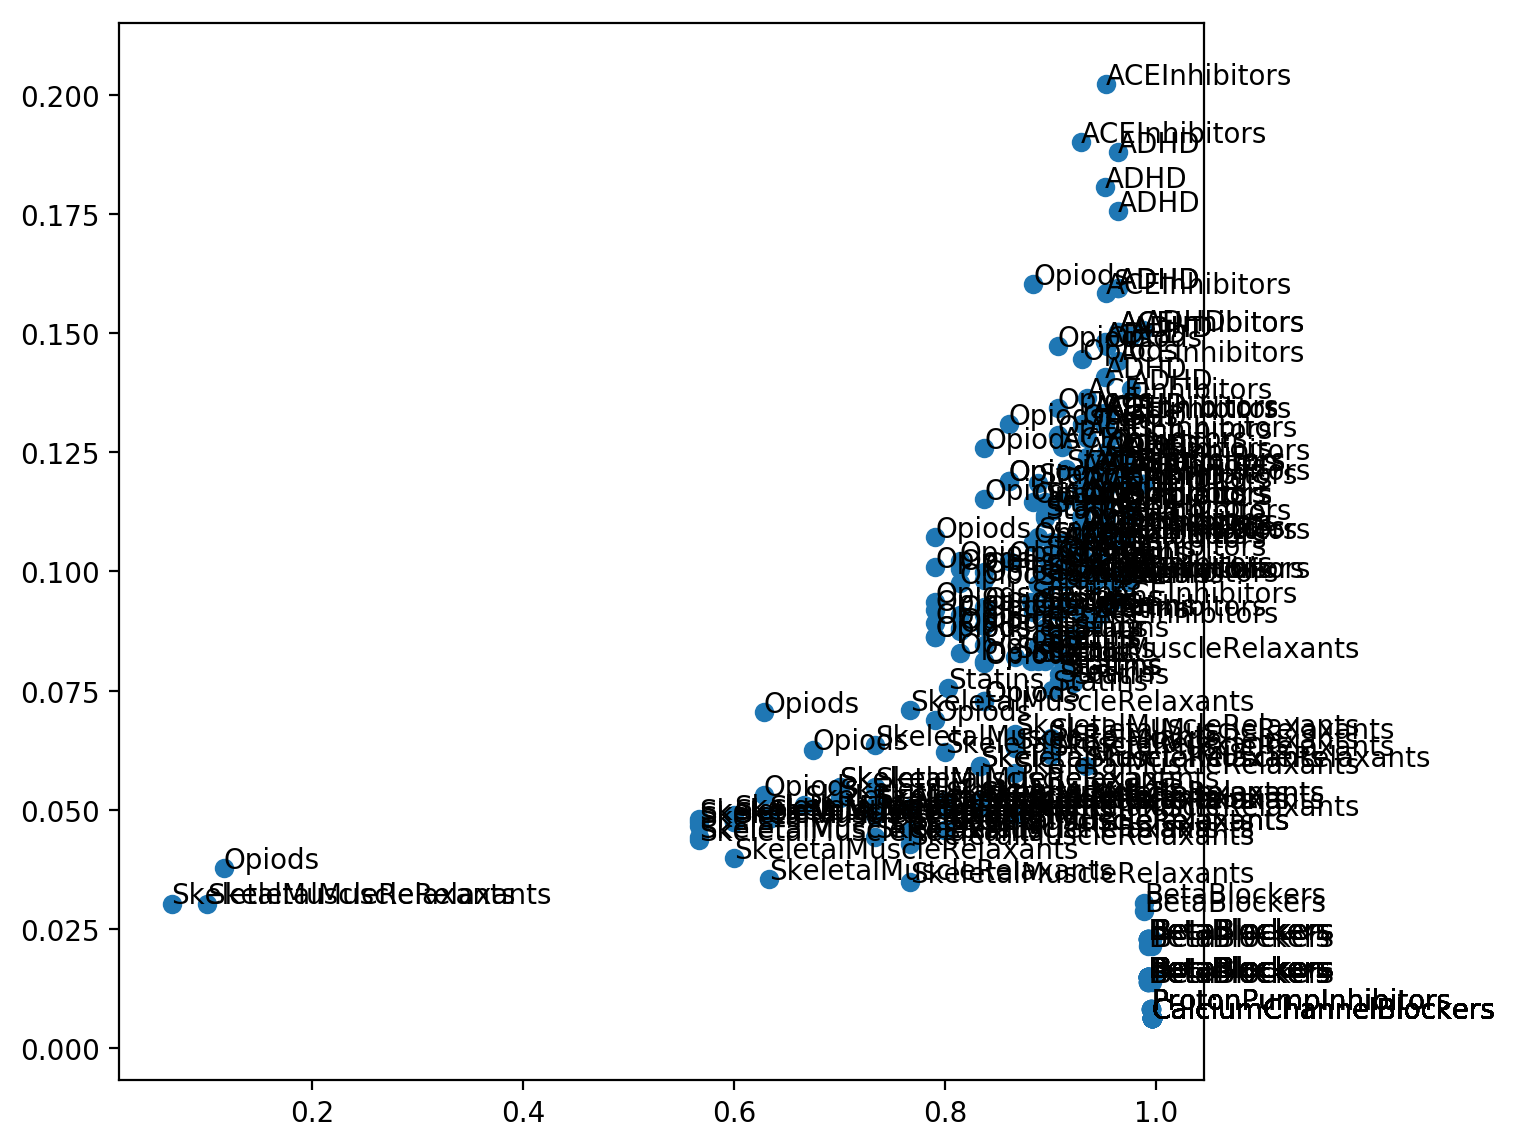

In [71]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

x = 'random_start_recall'

ax.scatter(
    df[x], 
    df['wss95_rs'], 
)
for i, row in df.iterrows():
    ax.text(
        row[x], 
        row['wss95_rs'], 
        row['dataset']
    )
plt.show()

[Text(0, 0, 'ACEInhibitors'),
 Text(0, 0, 'ADHD'),
 Text(0, 0, 'AtypicalAntipsychotics'),
 Text(0, 0, 'BetaBlockers'),
 Text(0, 0, 'CalciumChannelBlockers'),
 Text(0, 0, 'Opiods'),
 Text(0, 0, 'OralHypoglycemics'),
 Text(0, 0, 'ProtonPumpInhibitors'),
 Text(0, 0, 'SkeletalMuscleRelaxants'),
 Text(0, 0, 'Statins'),
 Text(0, 0, 'Triptans')]

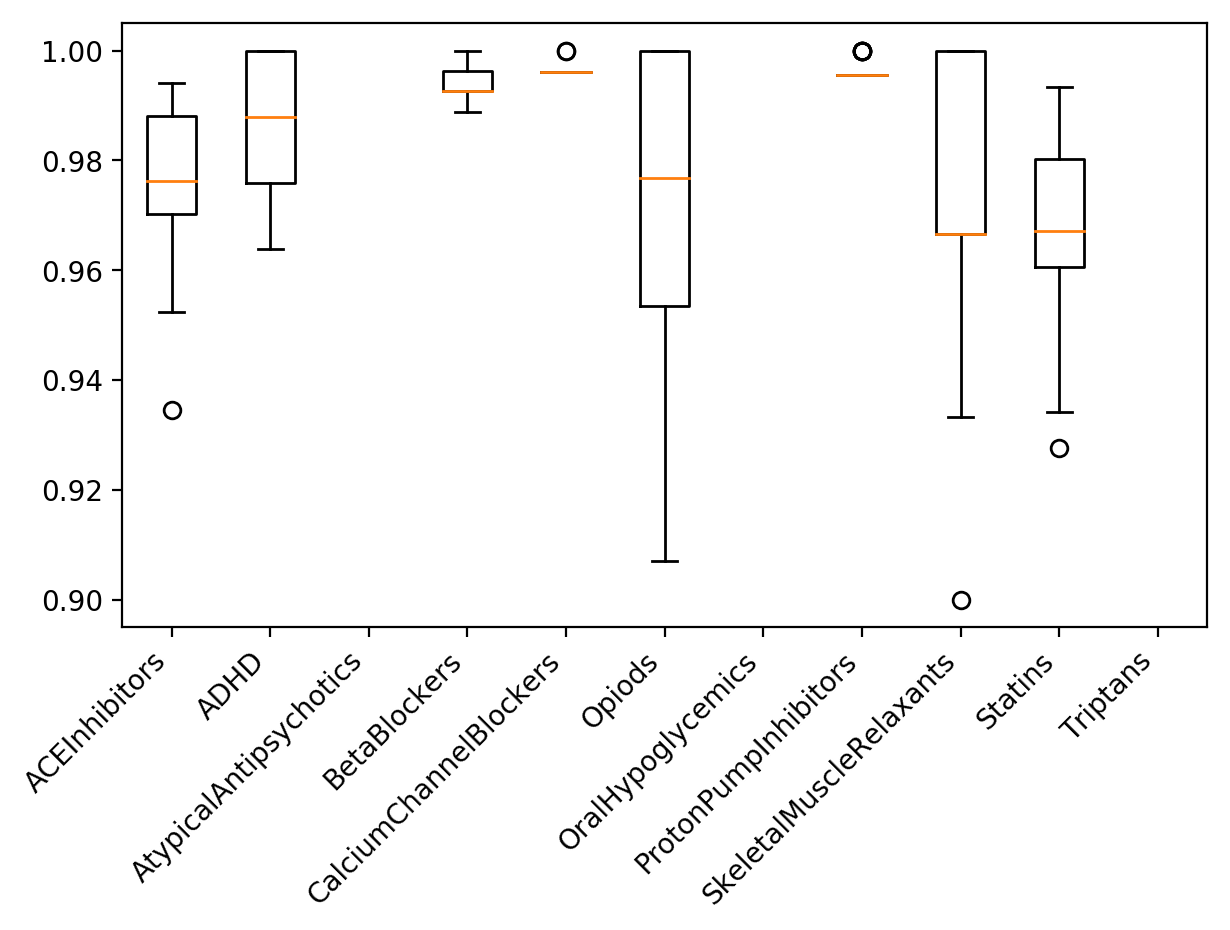

In [80]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

datasets = results_df['dataset'].unique()

ax.boxplot([results_df[results_df['dataset']==d]['recall_rs'].dropna() for d in datasets])

ax.set_xticklabels(datasets, rotation=45,ha="right")